# N2V Prediction
Please run the 'N2V-Convallaria-1-Training' notebook first.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from tifffile import imread

from unet.model import UNet
from pn2v.utils import denormalize
from pn2v.utils import normalize
from pn2v.utils import PSNR
from pn2v import utils
from pn2v import prediction
import pn2v.training
from pn2v import histNoiseModel

# See if we can use a GPU
device=utils.getDevice()

CUDA available? True


### Load Data

In [3]:
# We need the training data in order to calulate 'mean' and 'std' for normalization
path='data/Convallaria_diaphragm/'

# Load the test data
dataTest=imread(path+"20190520_tl_25um_50msec_05pc_488_130EM_Conv.tif")[:,:512,:512] 
# We are loading only a sub image to spped up computation

# We estimate the ground truth by averaging.
dataTestGT=np.mean(dataTest[:,...],axis=0)[np.newaxis,...]


### Load the Network

In [4]:
# Load the network, created in the 'Convallaria-2-Training' notebook
net=torch.load(path+"/last_conv_N2V.net")

### Evaluation

image: 0
PSNR input 29.009240856174337
PSNR N2V 35.78717790498089
-----------------------------------
image: 1
PSNR input 29.018589127299936
PSNR N2V 35.78717790498089
-----------------------------------
image: 2
PSNR input 29.035458856560645
PSNR N2V 35.78717790498089
-----------------------------------
image: 3
PSNR input 28.990347509982925
PSNR N2V 35.78717790498089
-----------------------------------
image: 4
PSNR input 29.002852113680238
PSNR N2V 35.78717790498089
-----------------------------------
image: 5
PSNR input 29.02402327393454
PSNR N2V 35.78717790498089
-----------------------------------
image: 6
PSNR input 29.032053580418268
PSNR N2V 35.78717790498089
-----------------------------------
image: 7
PSNR input 29.017435705343363
PSNR N2V 35.78717790498089
-----------------------------------
image: 8
PSNR input 29.003677692102134
PSNR N2V 35.78717790498089
-----------------------------------
image: 9
PSNR input 28.991348421709475
PSNR N2V 35.78717790498089
-----------------

image: 80
PSNR input 28.957840957402226
PSNR N2V 35.78717790498089
-----------------------------------
image: 81
PSNR input 28.940414811710117
PSNR N2V 35.78717790498089
-----------------------------------
image: 82
PSNR input 28.991915288787613
PSNR N2V 35.78717790498089
-----------------------------------
image: 83
PSNR input 29.023941316831703
PSNR N2V 35.78717790498089
-----------------------------------
image: 84
PSNR input 28.979363428547718
PSNR N2V 35.78717790498089
-----------------------------------
image: 85
PSNR input 28.977253844527432
PSNR N2V 35.78717790498089
-----------------------------------
image: 86
PSNR input 28.93295570861992
PSNR N2V 35.78717790498089
-----------------------------------
image: 87
PSNR input 28.911831115485445
PSNR N2V 35.78717790498089
-----------------------------------
image: 88
PSNR input 28.98025614483497
PSNR N2V 35.78717790498089
-----------------------------------
image: 89
PSNR input 28.94848133894456
PSNR N2V 35.78717790498089
---------

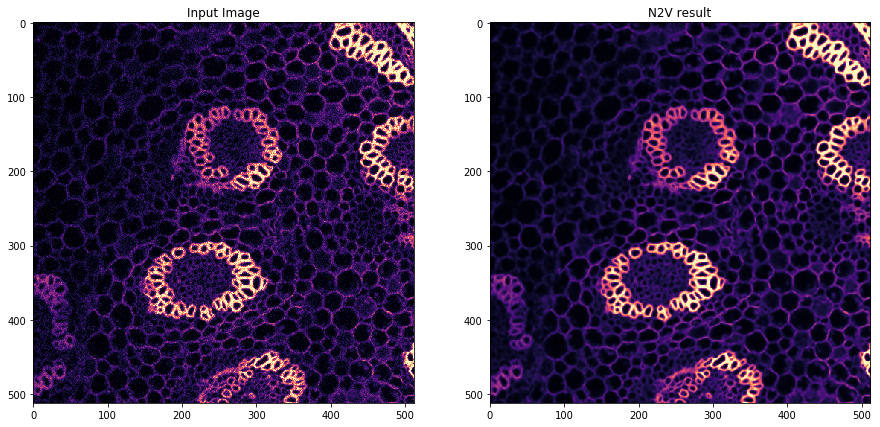

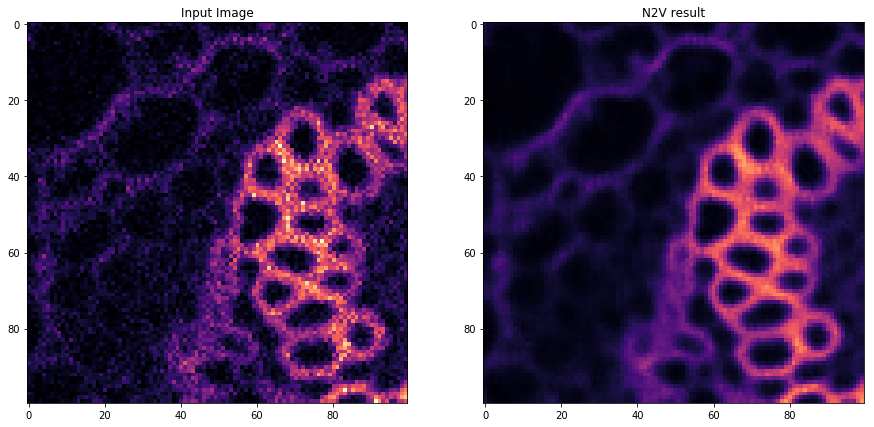

Avg PSNR N2V: 35.797845723613825 +-(2SEM) 0.007000398213986679


In [6]:
# Now we are processing data and calculating PSNR values.
n2vRes=[]
resultImgs=[]
inputImgs=[]

# We iterate over all test images.
for index in range(dataTest.shape[0]):
    
    im=dataTest[index]
    gt=dataTestGT[0] # The ground truth is the same for all images
    
    # We are using tiling to fit the image into memory
    # If you get an error try a smaller patch size (ps)
    n2vResult = prediction.tiledPredict(im, net ,ps=256, overlap=48,
                                            device=device, noiseModel=None)
    
    
    inputImgs.append(im)

    rangePSNR=np.max(gt)-np.min(gt)
    n2vPrior=PSNR(gt, n2vResult,rangePSNR )
    n2vRes.append(psnrPrior)

    print ("image:",index)
    print ("PSNR input",PSNR(gt, im, rangePSNR))
    print ("PSNR N2V",psnrPrior) # Without info from masked pixel
    print ('-----------------------------------')
    
    
# We display the results for the last test image       
vmi=np.percentile(gt,0.01)
vma=np.percentile(gt,99)

plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.title(label='Input Image')
plt.imshow(im, vmax=vma, vmin=vmi, cmap='magma')

plt.subplot(1, 2, 2)
plt.title(label='N2V result')
plt.imshow(n2vResult, vmax=vma, vmin=vmi, cmap='magma')

plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.title(label='Input Image')
plt.imshow(im[100:200,150:250], vmax=vma, vmin=vmi, cmap='magma')

plt.subplot(1, 2, 2)
plt.title(label='N2V result')
plt.imshow(n2vResult[100:200,150:250], vmax=vma, vmin=vmi, cmap='magma')
plt.show()

print("Avg PSNR N2V:", np.mean(np.array(meanRes) ), '+-(2SEM)',2*np.std(np.array(meanRes) )/np.sqrt(float(len(meanRes)) ) )